___
## <span style='color:#0d5874'> TP2 : Introduction aux modèles génératifs </span>
___

<span style='color:Red'>**L’objectif de cette séance de TP est de réaliser un bref tour d’horizon des auto-encodeurs**</span>

Ce TP s'effectue individuellement ou en binome. Veuillez respecter les consignes suivantes pour le rendu de votre travail :

* Renommez le selon le format suivant : "DL_2023_TP_AE_prenom1_nom1_prenom2_nom2.ipynb".
* Veillez à ce que votre nom et prénom soient complétés dans la cellule ci-dessous.
* Veillez à avoir bien exécuté toutes les cellules de code et que les résultats soient tous bien visible dans le notebook sans nécessiter une ré-exécution.
* Partagez le notebook avec hana.sebia@univ-lyon1.fr

Veuillez compléter vos noms et prénoms ci-dessous :

*   **Prenom 1** : ...
*   **Nom 1** : ...
*   **Prenom 2** : ...
*   **Nom 2** : ...

---
<span style='color:#0d5874'> **Exercice 1 : Autoencodeurs et génération d’images** </span>

---

![autoencoder-architecture.png](autoencoder-architecture.png)



Cet exercice présente l’utilisation des autoencodeurs avec PyTorch. Nous allons utiliser un modèle simple, entièrement connecté, permettant de compresser une image en une représentation vectorielle. Cet exercice utilise MNIST comme jeu de données vu précédemment dans le TP1.

In [1]:
# Imports liés à torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.utils import make_grid



# Matplotlib
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'mps'

In [2]:
BATCH_SIZE = 128

transform = transforms.Compose([transforms.ToTensor(),  transforms.Normalize((0.5,), (0.5,))])

# On télécharge et on créer la dataset d'entraienement à l'aide du module datasets de torchvision
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transform,
                               download=True)

# On télécharge et on créer la dataset de test à l'aide du module datasets de torchvision
valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transform)

# On définit le data loaders d'entraienement . Le data loaders permet de créer des batchs. On doit lui renseigner le batch size.
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

# On définit le data loaders de validation . 
valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)




---
<span style='color:Green'>**Question**</span> 3 points

En utilisant l’interface [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) de PyTorch, écrire le code qui définit un modèle autoencodeur entièrement connecté.

Ce modèle prend en entrée une image de dimensions 28×28 sous forme d’un vecteur aplati de longeur 784. On définira une variable latent_dimension qui permet de contrôler la taille du code z en sortie de l’encodeur.

Le décodeur devra prendre en entrée un code z de longueur latent_dimension et produire un vecteur aplati de longueur 28×28=784 (identique à l’image). On choisira une valeur raisonnable pour la dimension du code (par exemple, entre 30 et 250).

encoder : 

1. Linear(in_features=784, out_features=1024, bias=True) ReLU()
2. Linear(in_features=1024, out_features=256, bias=True) ReLU()
3. Linear(in_features=256, out_features=128, bias=True)

decoder:

1. Linear(in_features=128, out_features=256, bias=True) ReLU()
2. Linear(in_features=256, out_features=1024, bias=True) ReLU()
3. Linear(in_features=1024, out_features=784, bias=True) Sigmoid()

---

**Indice**
Indice: l’utilisation de la méthode [.view()](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) ou de la couche [nn.Flatten()](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) peut être utile pour ré-arranger les tenseurs avant ou après les couches linéaires. Par exemple, x.view(-1, 1, 28, 28) permet de transformer un tenseur de dimensions 784 en un tenseur de dimensions (batch, 1, 28, 28)…

In [3]:
class Auto_encoder(nn.Module):
    
    def __init__(self,latent_dimension): # On définit 
        super(Auto_encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dimension)
        )

        self.decoder = nn.Sequential(
        
            nn.Linear(latent_dimension, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),
            nn.Sigmoid(),
        )
    
    def forward(self, x): # on défini le passage de nos données
            x = torch.flatten(x,1)
            z = self.encoder(x)
            x_hat = self.decoder(z) 
            x_hat = x_hat.view(-1,1,28,28)
            return x_hat
    
auto_encoder = Auto_encoder(latent_dimension = 128)
print(auto_encoder)

Auto_encoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


---
<span style='color:Green'>**Question**</span>

Initialisee la loss; Comme paramétre de criterion on prendra la L1Loss et l'optimizer Adam avec lr=0.0001.

---


In [4]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(auto_encoder.parameters(),lr=0.0001)

---
<span style='color:Green'>**Question**</span> 0.5

Créer une fonction validate qui permettra d'évaluer notre modèle.

---


In [5]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, _ in valid_loader:
    
        X = X.to(device)
        
        # Forward pass and record loss
        X_hat = model(X)
        loss = criterion(X_hat, X)
        running_loss += loss.item()
        
    running_loss /= len(valid_loader)
    return running_loss

---
<span style='color:Green'>**Question**</span> 1 points

---
Créer une fonction Train qui permettra d'entrainer notre modèle elle prendra en paramètre : 

--- 
**Note**
Utiliser avant la fonction validate la fonction [.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html) pour désactiver le gradient.

---

In [6]:
def train(model, train_loader, optimizer, criterion, device, epochs=25):
    model = model.to(device)
    model.train()
    
    print('Start Training')
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (X,_) in enumerate(train_loader):
            
            X = X.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            X_hat = model(X)
            loss = criterion(X_hat, X)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
    
        running_loss /= len(train_loader)
        
        with torch.no_grad():
            running_loss_validate = validate(valid_loader, model, criterion)
            
        print(f" ecpochs: {epoch}, loss: {running_loss:.4f}, loss_validate:{running_loss_validate:.4f}")
            
    print('Finished Training')

In [7]:
train(auto_encoder,train_loader,optimizer,criterion,device)

Start Training


/opt/homebrew/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


 ecpochs: 0, loss: 0.9630, loss_validate:0.9433
 ecpochs: 1, loss: 0.9404, loss_validate:0.9297
 ecpochs: 2, loss: 0.9250, loss_validate:0.9200
 ecpochs: 3, loss: 0.9137, loss_validate:0.9051
 ecpochs: 4, loss: 0.9029, loss_validate:0.8964
 ecpochs: 5, loss: 0.8960, loss_validate:0.8910
 ecpochs: 6, loss: 0.8923, loss_validate:0.8882
 ecpochs: 7, loss: 0.8896, loss_validate:0.8855
 ecpochs: 8, loss: 0.8870, loss_validate:0.8833
 ecpochs: 9, loss: 0.8848, loss_validate:0.8812
 ecpochs: 10, loss: 0.8832, loss_validate:0.8800
 ecpochs: 11, loss: 0.8819, loss_validate:0.8789
 ecpochs: 12, loss: 0.8808, loss_validate:0.8778
 ecpochs: 13, loss: 0.8798, loss_validate:0.8769
 ecpochs: 14, loss: 0.8790, loss_validate:0.8762
 ecpochs: 15, loss: 0.8781, loss_validate:0.8754
 ecpochs: 16, loss: 0.8774, loss_validate:0.8748
 ecpochs: 17, loss: 0.8768, loss_validate:0.8742
 ecpochs: 18, loss: 0.8762, loss_validate:0.8736
 ecpochs: 19, loss: 0.8756, loss_validate:0.8730
 ecpochs: 20, loss: 0.8750, lo

**Visualiser les images produites par l'auto-encoder avec la fonction suivante:**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


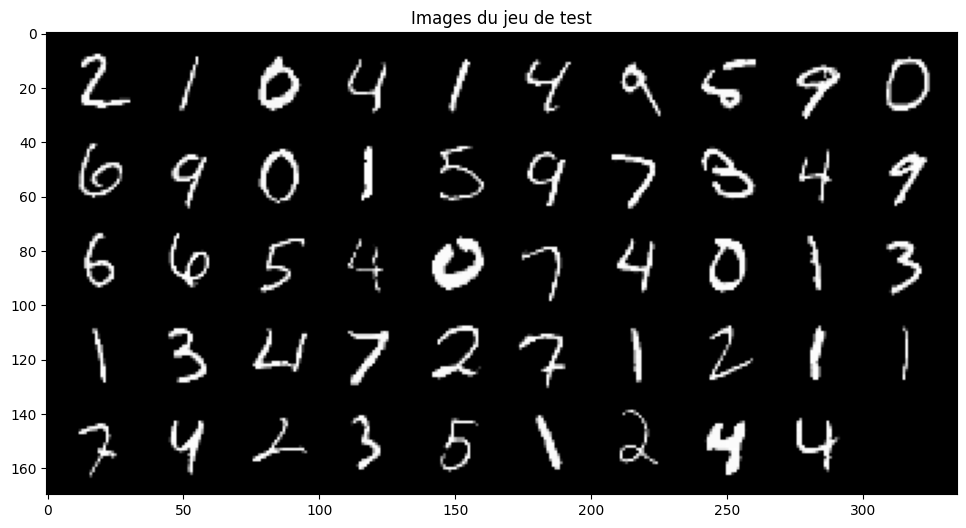

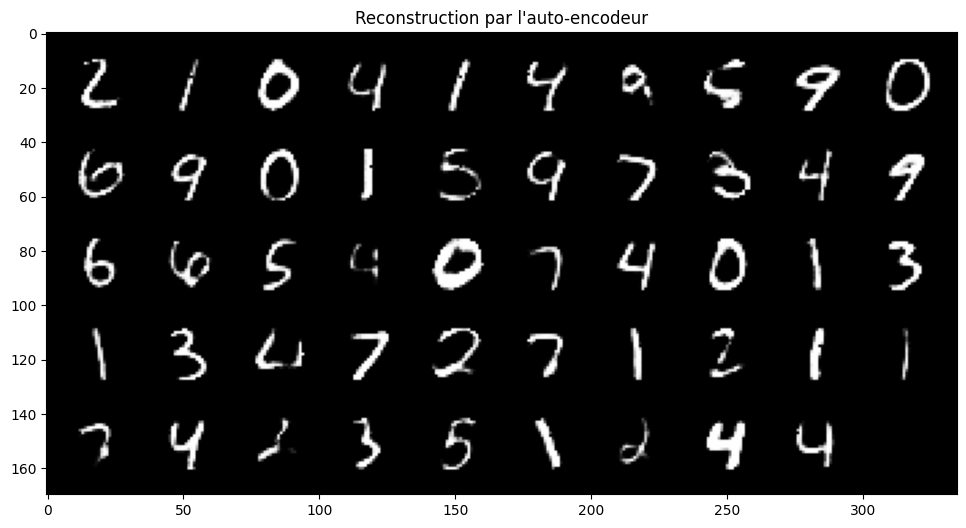

In [8]:
net = auto_encoder.eval()
test_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=False)


def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

def visualize_reconstructions(net, images, device="cpu"):
    # Mode inférence
    with torch.no_grad():
        images = images.to(device)
        net.to(device)
        reconstructions = net(images)
        image_grid = make_grid(reconstructions[1:50], 10, 5)
        return image_grid.squeeze(0)

images, _ = next(iter(test_dataloader))

# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test")
show_grid(make_grid(images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(auto_encoder, images))

---
<span style='color:#0d5874'> **Exercice 2 : Autoencodeurs convolutif et génération d’images** </span>

---

**Préambule**

---
Pour commencer, nous allons charger en mémoire les données de Fashion-MNIST et en visualiser quelques unes. Ces images sont similaires en format aux données de MNIST : 28x28 pixels en niveaux de gris.

Ce jeu de données est préintégré dans la bibliothèque torchvision:

In [9]:
from torchvision.datasets import FashionMNIST

train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())
valid_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())

# Création du DataLoader pour charger les données
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True)


Nous pouvons visualiser quelques unes de ces images:

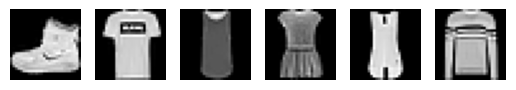

In [10]:
n_images = 5

fig = plt.figure()
for i, (image, label) in enumerate(train_dataset):
    fig.add_subplot(1, n_images+1, i+1)
    plt.imshow(ToPILImage()(image), cmap="gray")
    plt.axis("off")
    if i >= n_images:
        break
plt.show()

**Implémentation**

---

Notre modèle sera un auto-encodeur convolutif doté de l’architecture ci-dessous.

Pour l’encodeur :

* une couche de convolution (kernel_size=4, in_channels=1, out_channels=32, stride=2, padding=1, activation ReLU)

* une couche de convolution (kernel_size=4, in_channels=32, out_channels=64, stride=2, padding=1, activation ReLU)

* une couche linéaire (in_features=64\*7\*7, out_features=latent_dimension)

Pour le décodeur:

* une couche linéaire (in_features=latent_dimension, out_features=64\*7\*7, activation ReLU)

* une couche de convolution transposée (kernel size=4, in_channels=64, out_channels=32, stride=2, padding=1, activation ReLU)

* une couche de convolution transposée (kernel size=4, in_channels=32, out_channels=1, stride=2, padding=1, activation sigmoide)

--- 
**Note**
Les filtres convolutifs sont choisis de taille 4x4 afin d’éviter des problèmes [d’aliasing](https://distill.pub/2016/deconv-checkerboard/).

---

<span style='color:Green'>**Question**</span> 3 points

---

Compléter l’implémentation ci-dessous de l’auto-encodeur dont l’architecture vient d’être décrite. Cette implémentation utilise l’interface torch.nn.Module dont la documentation peut vous être utile.

En plus de la reconstruction par l’auto-encodeur, on souhaite que la méthode forward() renvoie également le code intermédiaire z (un vecteur de longueur latent_dimension) obtenu après le passage dans le décodeur.

--- 

**Indice**
l’utilisation de la méthode .view() ou de la couche nn.Flatten() peut être utile pour ré-arranger les tenseurs avant ou après les couches linéaires. Par exemple, x.view(-1, 64, 7, 7) permet de transformer un tenseur de dimensions (batch, 3136) en un tenseur de dimensions (batch, 64, 7, 7)…

---


In [11]:
class AutoEncoder_conv(nn.Module):
    def __init__(self, latent_dimension):
        super(AutoEncoder_conv, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
                                     nn.BatchNorm2d(32), 
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                     nn.Linear(in_features=64*7*7, out_features=latent_dimension)
                                     )
        self.decoder_linear = nn.Linear(in_features=latent_dimension, out_features=64*7*7)
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                                     nn.BatchNorm2d(32),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
                                     nn.BatchNorm2d(1),
                                     nn.Sigmoid(),
                                    )

    def forward(self, x):
        z = self.encoder(x)
        hat_x = F.relu(self.decoder_linear(z))
        hat_x = hat_x.view(-1, 64, 7, 7)
        hat_x = self.decoder(hat_x)
        return hat_x
    
autoencoder_conv = AutoEncoder_conv(latent_dimension=10)
print(autoencoder_conv)

AutoEncoder_conv(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=10, bias=True)
  )
  (decoder_linear): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Sigmoid()
  )
)


**Entraînement** 0.5 points

---

Une fois le modèle implémenté, nous pouvons utiliser la fonction train et validate implémentées précedemment pour réaliser l'apprentissage. L’optimisation se fait selon le critère choisi dans la variable criterion (par défaut, il s’agit de l’erreur quadratique moyenne comme critère de reconstruction).

In [12]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder_conv.parameters(),lr=1e-3, weight_decay=1e-5)

In [13]:
train(autoencoder_conv,train_loader,optimizer,criterion,device, epochs=25)

Start Training
 ecpochs: 0, loss: 0.0573, loss_validate:0.0359
 ecpochs: 1, loss: 0.0179, loss_validate:0.0162
 ecpochs: 2, loss: 0.0157, loss_validate:0.0154
 ecpochs: 3, loss: 0.0149, loss_validate:0.0153
 ecpochs: 4, loss: 0.0144, loss_validate:0.0144
 ecpochs: 5, loss: 0.0141, loss_validate:0.0140
 ecpochs: 6, loss: 0.0138, loss_validate:0.0138
 ecpochs: 7, loss: 0.0136, loss_validate:0.0135
 ecpochs: 8, loss: 0.0134, loss_validate:0.0134
 ecpochs: 9, loss: 0.0132, loss_validate:0.0136
 ecpochs: 10, loss: 0.0130, loss_validate:0.0130
 ecpochs: 11, loss: 0.0129, loss_validate:0.0130
 ecpochs: 12, loss: 0.0128, loss_validate:0.0129
 ecpochs: 13, loss: 0.0127, loss_validate:0.0127
 ecpochs: 14, loss: 0.0126, loss_validate:0.0127
 ecpochs: 15, loss: 0.0125, loss_validate:0.0126
 ecpochs: 16, loss: 0.0124, loss_validate:0.0126
 ecpochs: 17, loss: 0.0124, loss_validate:0.0125
 ecpochs: 18, loss: 0.0123, loss_validate:0.0124
 ecpochs: 19, loss: 0.0123, loss_validate:0.0125
 ecpochs: 20, l

**Visualiser les images produites par l'auto-encoder et comparer avec les images précédentes** 0.5 points

--- 

Une fois l’apprentissage terminé, nous pouvons visualiser quelques reconstructions obtenues grâce à l’auto-encodeur. Cela permet de jauger qualitativement des performances du modèle en reconstruction.

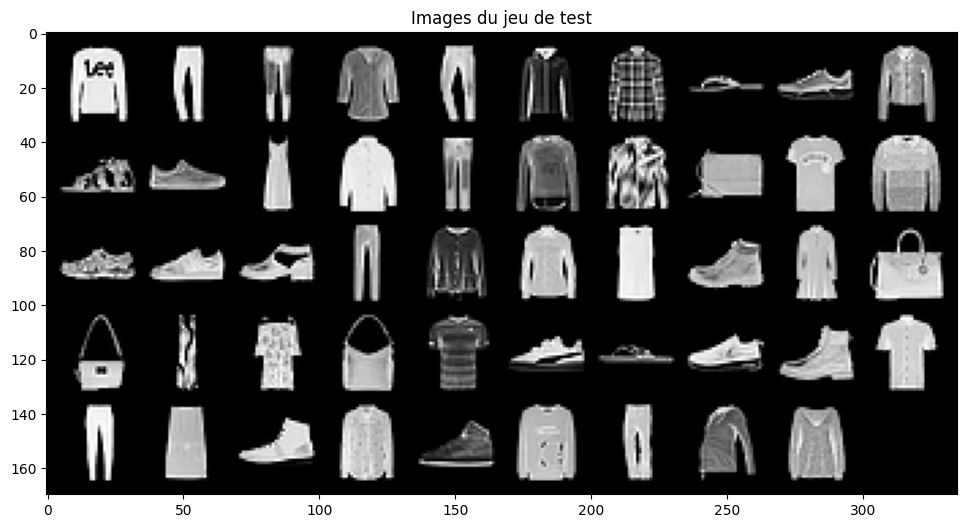

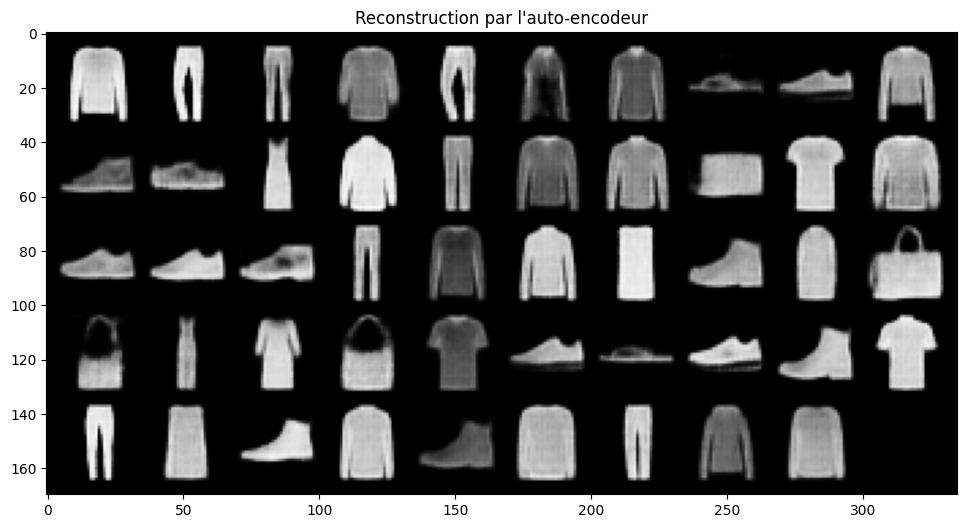

In [15]:
net = autoencoder_conv.eval()
test_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)


def show_grid(grid):
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

def visualize_reconstructions(net, images, device="cpu"):
    # Mode inférence
    with torch.no_grad():
        images = images.to(device)
        net.to(device)
        reconstructions = net(images)
        image_grid = make_grid(reconstructions[1:50], 10, 5)
        return image_grid

images, _ = next(iter(test_loader))

# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test")
show_grid(make_grid(images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(net, images))

**Débruitage**

---

Une capacité intéressante des auto-encodeurs est leur capacité à apprendre des filtres robustes au bruit. En particulier, en bruitant légèrement une observation, on retrouve généralement la reconstruction moyenne non-bruitée. Cette propriété de débruitage est particulièrement intéressante pour l’amélioration de la qualité des signaux (images, sons, etc.).

Observons la capacité de débruitage de notre auto-encodeur sur un échantillon d’images de test

---

<span style='color:Green'>**Question**</span> 0.5

---

Compléter le code ci-dessous pour ajouter un bruit blanc uniforme aux images de test contenues dans le tenseur images. Pensez à ajuster l’amplitude du bruit et à limiter les valeurs des pixels de sortie à la plage autorisée [0,1].

In [16]:
# Bruit blanc (uniforme) centré en 0
noise = torch.rand_like(images) - 0.5
# Ajout du bruit + troncature des valeurs en dehors de [0,1]
noisy_images = torch.clamp(images + 0.5 * noise, 0, 1)

---

<span style='color:Green'>**Question**</span>

---
Visualiser la reconstruction des images bruitées.


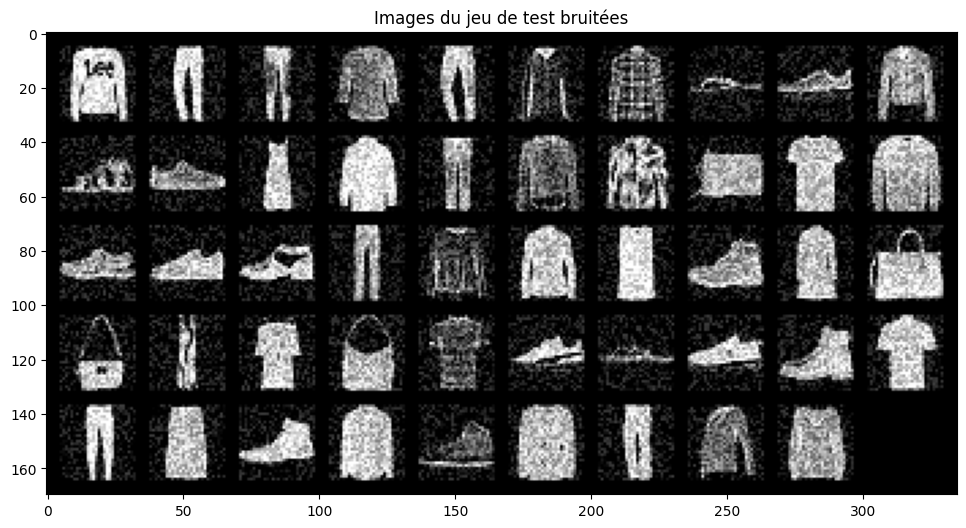

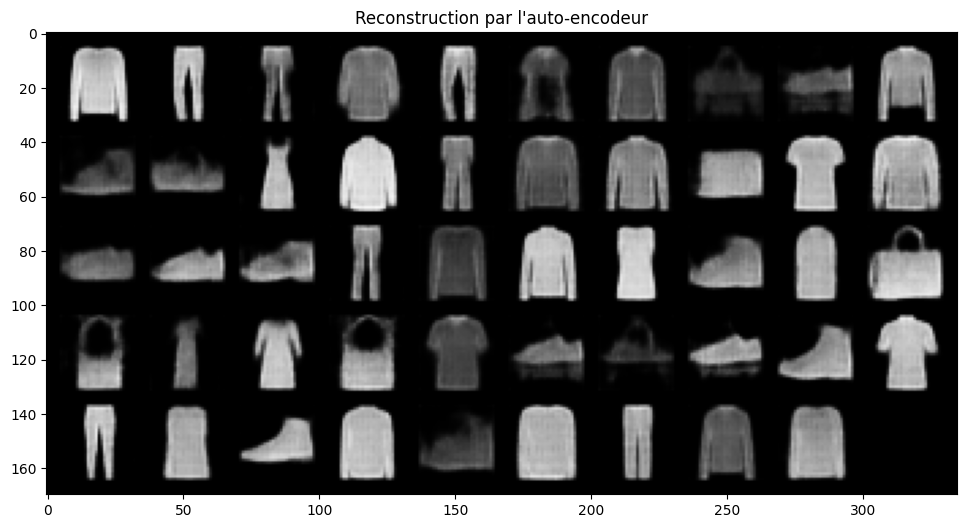

In [17]:
# Images de test
plt.figure(figsize=(12, 6))
plt.title("Images du jeu de test bruitées")
show_grid(make_grid(noisy_images[1:50],10,5))

# Reconstruction et visualisation des images reconstruites
plt.figure(figsize=(12, 6))
plt.title("Reconstruction par l'auto-encodeur")
show_grid(visualize_reconstructions(net, noisy_images))

---

<span style='color:Green'>**Question**</span> 1 point

---
Comparer les reconstructions des images bruitées aux reconstructions obtenues sur les images de test originales. Que constatez-vous ?

---

<span style='color:Green'>**Correction**</span>

---

Pour des bruits de faible amplitude, les images reconstruites sont moins bruitées. Autrement dit, l’auto-encodeur « débruite » en partie les images. En revanche, lorsque l’amplitude du bruit est forte, le signal utile de l’image disparaît et la sortie devient décorrélée de l’entrée.

---
<span style='color:#0d5874'> **Exercice 3 : Autoencodeurs variationnels** </span> 4.5 points

---

![vae-gaussian.png](vae-gaussian.png)

**Implémentation**

Nous allons à présent implémenter un VAE convolutif qui hérite de la même structure que l’auto-encodeur que nous avons précédemment défini. Pour nous simplifier les choses par la suite, nous allons commencer par séparer le sous-réseau qui définit l’encodeur de celui qui définit le décodeur.

<span style='color:Green'>**Question**</span>

En reprenant ce qui a été fait plus haut pour l’auto-encodeur classique, compléter les implémentations ci-dessous de l’encodeur et du décodeur pour le VAE. On rappelle que, contrairement à l’auto-encodeur, la sortie de l’encodeur est double :

+ le vecteur <span style='color:Red'>mu</span> qui contient la moyenne de la gaussienne dans l’espace latent,
+ le vecteur <span style='color:Red'>sigma</span> qui contient les variances selon les différentes directions de la gaussienne dans l’espace latent.


le vecteur sigma qui contient les variances selon les différentes directions de la gaussienne dans l’espace latent.

Ces valeurs seront les paramètres de la gaussienne associée à une observation x. Ces deux vecteurs ont pour dimension la dimension de l’espace latent.

In [18]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                   )
        self.linear1 = nn.Linear(in_features=64*7*7, out_features=latent_dimension)
        self.linear2 = nn.Linear(in_features=64*7*7, out_features=latent_dimension)

    def forward(self, x):
        x = self.model(x)
        x_mu = self.linear1(x)
        x_logvar = self.linear2(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(in_features=latent_dimension, out_features=64*7*7)
        self.model = nn.Sequential(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
                                     nn.Sigmoid(),
                                    )

    def forward(self, z):
        hat_x = F.relu(self.linear(z))
        hat_x = hat_x.view(-1, 64, 7, 7)
        hat_x = self.model(hat_x)
        return hat_x


Nous allons à présent combiner l’encodeur et le décodeur pour former l’auto-encodeur variationnel complet. Il y a néanmoins une petite subtilité car nous devons implémenter l’astuce de reparamétrisation. Celle-ci est implémenter dans la méthode latent_sample

Lors d’un passage avant (forward), le schéma suivant doit se dérouler :

1. L’encodeur prend x en entrée et produit la moyenne mu et la variance logvar de la distribution. 

2. On tire un échantillon aléatoire z dans l’espace latent à l’aide de la méthode latent_sample. L’échantillonnage est fait selon la distribution gaussienne latente associée à x grâce à la reparamétrisation. Lors de l’inférence, on ne réalisera pas d’échantillonnage mais on se contentera d’utiliser la moyenne de la gaussienne.

3. L’échantillon aléatoire z est passé dans le décodeur de sorte à obtenir la reconstruction x_recon.

3 points

In [19]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        z = self.latent_sample(latent_mu, latent_logvar)
        x_recons = self.decoder(z)
        return x_recons, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
        
vae_encoder = VariationalAutoencoder(latent_dim = 128)
print(vae_encoder)

VariationalAutoencoder(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Flatten(start_dim=1, end_dim=-1)
    )
    (linear1): Linear(in_features=3136, out_features=128, bias=True)
    (linear2): Linear(in_features=3136, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=128, out_features=3136, bias=True)
    (model): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): Sigmoid()
    )
  )
)


Enfin, il reste à définir la fonction de coût du VAE. D’après le cours, on cherche à maximiser $\mathcal{L}$. Ici, on choisira de minimiser $-\mathcal{L}$ avec


$\mathcal{L}(\theta,\phi ;\boldsymbol{x}) =  \underbrace{\mathbb{E}_{q_\phi(\boldsymbol z | \boldsymbol x)} \left [ \log p_\theta(\boldsymbol x | \boldsymbol z) \right ]}_{\text{Esperance de la vraisemblance}} - \underbrace{KL\, \left (q_\phi(\boldsymbol z | \boldsymbol x) \, || \, p_\theta(\boldsymbol z)\right)}_{\text{ecart au prior}}$

La fonction de coût pour une reconstruction sur une seule donnée $x^{(i)}$ est approximée par :

$\mathcal{L}(\theta,\phi ;\boldsymbol x^{(i)}) \simeq - \frac{1}{2} \sum_j^d \bigl ( 1 + \log((\sigma_j^{(i)})^2) - (\mu_j^{(i)})^2 - (\sigma_j^{(i)})^2  \bigr) - \log p_\theta(\boldsymbol x^{(i)} | \boldsymbol z^{(i)})$

---
**Note**  2 points



Dans la plupart des cas, la vraisemblance est supposée gaussienne et la fonction de coût évaluant la reconstruction correspondera donc à l’erreur quadratique moyenne (F.mse_loss()). Dans notre cas, la distribution des valeurs des pixels de Fashion-MNIST est plutôt bimodale. Les images étant à valeurs entre 0 et 1, il est possible d’utiliser une entropie croisée binaire (F.bce_loss()) et c’est cette version qui donne les meilleurs résultats.

---
Le prior $p_{θ}(z)$ est supposé être donné par une loi normale centrée réduite. La divergence de Kullback-Leibler est alors donnée par:

$KL(q_\phi(\boldsymbol z | \boldsymbol x) || p_\theta(\boldsymbol z)) = \frac{1}{2} \bigl( \text{tr}(\boldsymbol \sigma \boldsymbol I) + \boldsymbol \mu^T \boldsymbol \mu - k - \log \text{det}(\boldsymbol \sigma \boldsymbol I)\big) = \frac{1}{2} \sum ( 1 + \log(\sigma) - \mu^2 - \exp^{\log(\sigma)} ) $

In [20]:
def vae_loss(hat_x, x, mu, logvar):
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

0.5 points

In [21]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        
        # Forward pass and record loss
        X_hat, latent_mu, latent_logvar = model(X)
        loss = vae_loss(X_hat, X, latent_mu, latent_logvar)
        running_loss += loss.item()
        
    running_loss /= len(valid_loader)
    return running_loss

1 points

In [22]:
def train(model, train_loader, optimizer, device, epochs=25):
    model = model.to(device)
    model.train()
    
    print('Start Training')
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (X,y_true) in enumerate(train_loader):
            
            X = X.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            X_hat, latent_mu, latent_logvar = model(X)
            loss = vae_loss(X_hat, X, latent_mu, latent_logvar)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
    
        running_loss /= len(train_loader)
        
        with torch.no_grad():
            running_loss_validate = validate(valid_loader, model, criterion)
            
        print(f" ecpochs: {epoch}, loss: {running_loss:.4f}, loss_validate:{running_loss_validate:.4f}")
            
    print('Finished Training')

In [23]:
criterion = vae_loss
optimizer = torch.optim.Adam(vae_encoder.parameters(),lr=0.0001)
train(vae_encoder,train_loader,optimizer,device)

Start Training
 ecpochs: 0, loss: 45618.8140, loss_validate:36705.7976
 ecpochs: 1, loss: 32003.6406, loss_validate:30355.3592
 ecpochs: 2, loss: 29708.7183, loss_validate:29052.7734
 ecpochs: 3, loss: 28767.1667, loss_validate:28348.1959
 ecpochs: 4, loss: 28197.7502, loss_validate:27888.8471
 ecpochs: 5, loss: 27799.2478, loss_validate:27562.5485
 ecpochs: 6, loss: 27504.2287, loss_validate:27301.1420
 ecpochs: 7, loss: 27264.9793, loss_validate:27086.5644
 ecpochs: 8, loss: 27066.3718, loss_validate:26904.8645
 ecpochs: 9, loss: 26896.9905, loss_validate:26747.0110
 ecpochs: 10, loss: 26750.4254, loss_validate:26664.7240
 ecpochs: 11, loss: 26620.5764, loss_validate:26516.4236
 ecpochs: 12, loss: 26505.7526, loss_validate:26392.7709
 ecpochs: 13, loss: 26405.1448, loss_validate:26306.0680
 ecpochs: 14, loss: 26319.0723, loss_validate:26229.6365
 ecpochs: 15, loss: 26238.7602, loss_validate:26141.5637
 ecpochs: 16, loss: 26170.3752, loss_validate:26082.2026
 ecpochs: 17, loss: 26106.

**Visualisation**

Ecrire le code qui permet de visualiser les images réelles et celles produites par le VAE puis comparer le résultat. 

---
<span style='color:#0d5874'> **Pour Aller plus loin : VAE conditionnel** </span>

---

Dans cette partie on souhaite procéder à la génération conditionnée de chiffre à l'aide d'un autoencodeur variationnel conditionnel. 

Pour commencer, on va s'inspirer du modèle de VAE implémenté précedemment qu'on adaptera. On souhaite dans notre cas conditionner le modèle au chiffre représenté par l'image. Cette information correspond dans le jeu de données à une étiquette sous la forme d’un entier de 0 à 9, que l’on représentera plus tard sous la forme d’un vecteur en encodage one-hot, c’est-à-dire : [0, 0, 0, 0, 0, 0, 1, 0, 0, 0] pour l’étiquette 6.

La longueur du vecteur de conditionnement est donc 10 (le nombre de classes du jeu de données).

---
<span style='color:Green'>**Question**</span>

Reprendre le code du VAE et l’adapter de sorte à ce que :
    
* l’encodeur accepte le vecteur de conditionnement comme deuxième argument dans la méthode ’.forward()’ . Il faudra notamment décider de l’endroit où injecter le vecteur de conditionnement (on pourra, par exemple, le concaténer au vecteur aplati des features obtenu en sortie des couches convolutives).

* le décodeur accepte le vecteur de conditionnement comme deuxième argument dans la méthode .forward(). On se contentera de concaténer le conditionnement au code latent z.

Attention, il ne faut pas oublier de modifier les dimensions des couches entièrement connectées lorsque cela est nécessaire. En effet, l’espace latent « change » de dimension lorsque que l’on concatène le vecteur de conditionnement au code latent…

**Indice** : torch.cat() peut vous être utile

---


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        ############# Votre code ici ################

    def forward(self, x, c):
        ############# Votre code ici ################
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        ############# Votre code ici ################

    def forward(self, z, c):
        ############# Votre code ici ################
        return hat_x

---

<span style='color:Green'>**Question**</span>

De la même façon, modifier l’implémentation de l’autoencodeur variationnel.

---

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        ############# Votre code ici ################

    def forward(self, x, c):
        ############# Votre code ici ################
        return hat_x, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

La boucle d’apprentissage ne change presque pas : il suffit d’encoder les étiquettes dans le format one-hot et de les fournir au VAE au moment du calcul de la reconstruction. 

In [ ]:
from tqdm.notebook import trange,tqdm

def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=32, device=device):
    # Création du DataLoader pour charger les données
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Définition de l'algorithme d'optimisation (Adam, variante de la SGD)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    # Choix de la fonction de coût
    criterion = vae_loss
    # Passe le modèle en mode "apprentissage"
    net = net.to(device)
    net = net.train()

    t = trange(1, epochs + 1, desc="Entraînement du modèle")
    for epoch in t:
        avg_loss = 0.
        # Parcours du dataset pour une epoch
        for images, labels in tqdm(train_dataloader):
            images = images.to(device)
            # Encodage one-hot des labels
            labels = F.one_hot(labels, num_classes=10).to(device)

            # Calcul de la reconstruction
            reconstructions, latent_mu, latent_logvar = net(images, labels)
            # Calcul de l'erreur
            loss = criterion(reconstructions, images, latent_mu, latent_logvar)

            # Rétropropagation du gradient
            optimizer.zero_grad()
            loss.backward()
            # Descente de gradient (une itération)
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.to("cpu").eval()

---

<span style='color:Green'>**Question**</span>

Entraîner le VAE conditionnel sur la base de données MNIST

---

In [ ]:
vae = VariationalAutoencoder(10)
vae = train_vae(vae, train_dataset)

---

<span style='color:Green'>**Question**</span>

Générer et visualiser des chiffres de différentes classes en échantillonnant dans la distribution conditionnelle. Le code latent est toujours échantillonné selon une loi normale centrée réduite, seul le vecteur de conditionnement change.

---